In [1]:
from core.runner import Runner
import tensorflow as tf

grid_length = 8

runner = Runner(
    grid_length=grid_length,
    main_layer_hidden_nodes=(40, 30, 20),
    branch1_hidden_nodes=(),
    branch2_hidden_nodes=(),
    activation="swish",
    exploration_rate=0.5,
    learning_rate=0.001,
    environment_mode="spinfoam_vertex"
)

2023-02-03 21:59:51.648289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
half_batch_size = tf.constant(500)
n_iterations = tf.constant(int(1e4))
# n_iterations = tf.constant(500)

# evaluate_every_n_iterations = tf.constant(int(1e2))
evaluate_every_n_iterations = tf.constant(int(1e3))
evaluation_batch_size = tf.constant(int(5e4))
# evaluation_batch_sizes = tf.constant([int(1e4), int(5e4), int(1e5), int(5e5)])

ave_losses, distr_js_dists, agent_obss = runner.train_agent(
    half_batch_size, n_iterations, evaluate_every_n_iterations, evaluation_batch_size
)

Nth iteration: 1000 Average Loss: 4.8365
Nth iteration: 2000 Average Loss: 4.47398233
Nth iteration: 3000 Average Loss: 3.74598408
Nth iteration: 4000 Average Loss: 3.16208243
Nth iteration: 5000 Average Loss: 2.94628215
Nth iteration: 6000 Average Loss: 3.19484496
Nth iteration: 7000 Average Loss: 2.806458
Nth iteration: 8000 Average Loss: 3.72179627
Nth iteration: 9000 Average Loss: 2.57424021
Nth iteration: 10000 Average Loss: 2.63049078


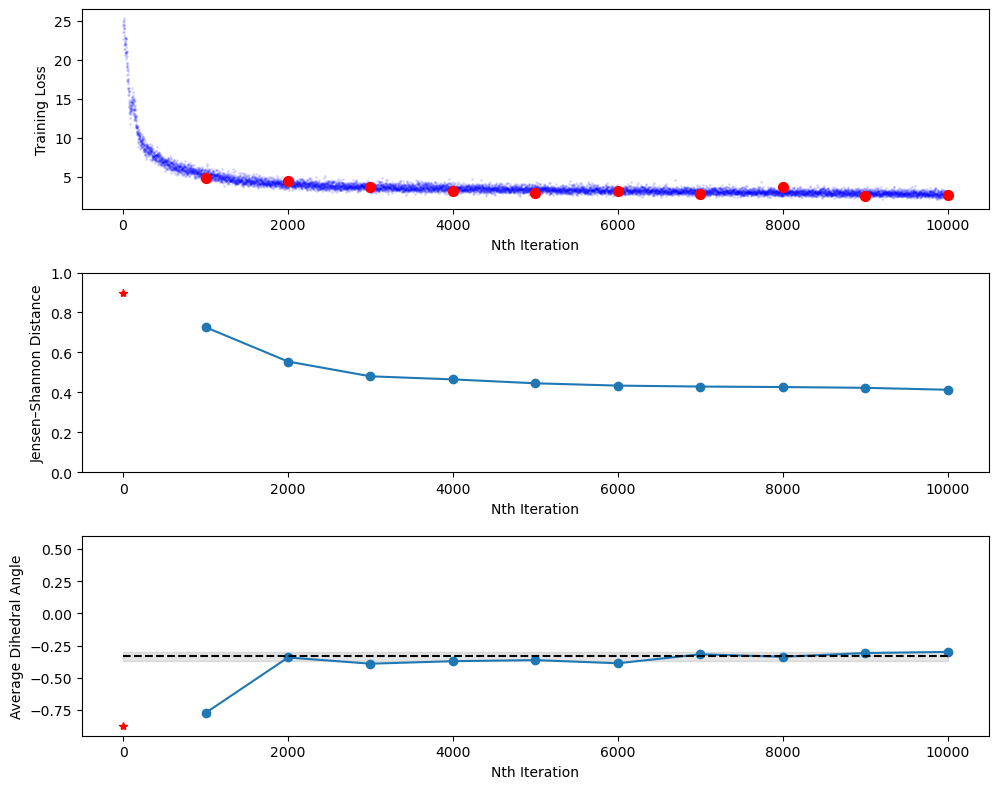

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(
    train_iters, eval_iters, losses, js_dists, obs, theo_obs, figsize=(10, 8)
):
    fig, ax = plt.subplots(3, 1, figsize=figsize)

    ax[0].scatter(train_iters, losses, marker='.', alpha=0.1, c='b', s=5)
    ax[0].scatter(eval_iters, losses[eval_iters-1], marker='o', c='r', s=50)
    ax[0].set_ylabel('Training Loss')
    ax[0].set_xlabel('Nth Iteration')


    ax[1].plot(eval_iters, js_dists[1:], marker='o')
    ax[1].plot(0, js_dists[0], marker='*', c='r')
    ax[1].set_ylabel('Jensen–Shannon Distance')
    ax[1].set_xlabel('Nth Iteration')
    ax[1].set_ylim(0, 1)

    ax[2].plot(eval_iters, obs[1:], marker='o')
    ax[2].plot(0, obs[0], marker='*', c='r')
    ax[2].fill_between(
        x=[0, eval_iters[-1]], y1=1.1*theo_obs, y2=0.9*theo_obs, 
        alpha=0.1, color='k'
    )
    ax[2].hlines(theo_obs, 0, eval_iters[-1], linestyles='dashed', colors='k')


    ax[2].set_ylabel('Average Dihedral Angle')
    ax[2].set_xlabel('Nth Iteration')
    ax[2].set_ylim(-0.95, 0.6)
    
    plt.tight_layout()
    

training_iterations = np.arange(n_iterations) + 1
evaluation_iterations = np.arange(
    evaluate_every_n_iterations, 
    n_iterations+1,
    evaluate_every_n_iterations
)

training_losses = ave_losses.numpy()

js_distances = distr_js_dists.numpy()

observables = agent_obss.numpy()
theoretical_obs = runner.env.theoretical_ave_dihedral_angle.numpy()


plot_results(
    training_iterations, evaluation_iterations, training_losses, 
    js_distances, observables, theoretical_obs, figsize=(10, 8)
)

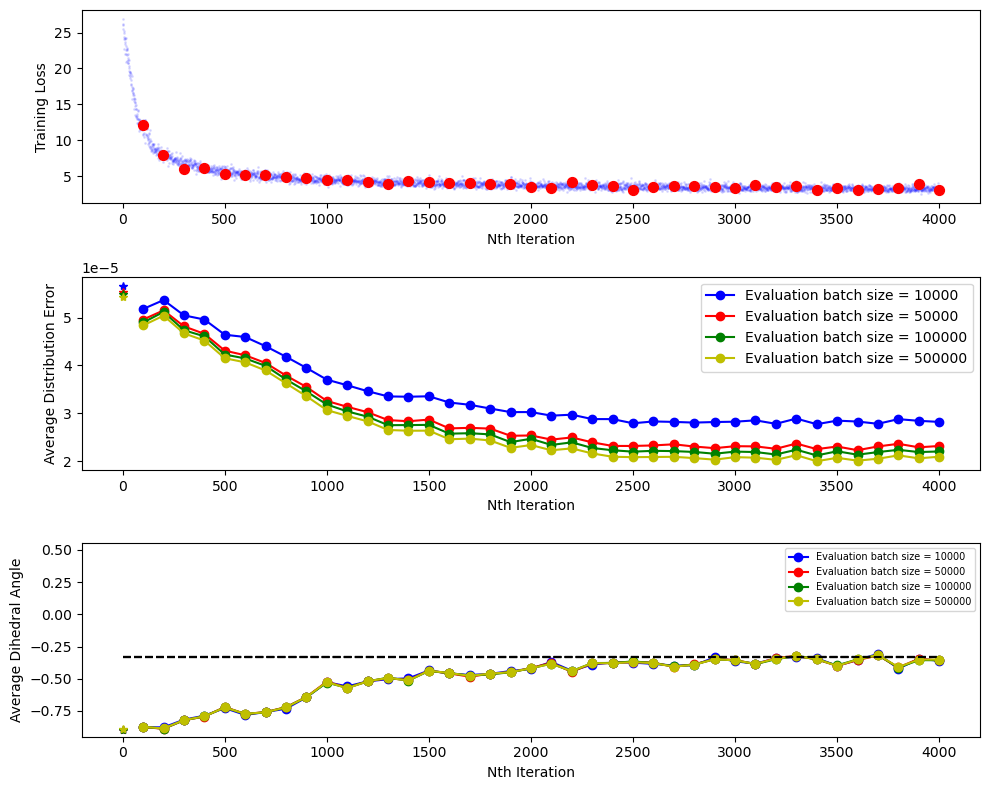

In [4]:
import matplotlib.pyplot as plt

def plot_results(
    train_iters, eval_iters, losses, distr_errs, obs, theo_obs, eval_sizes, 
    figsize=(10, 8), colors=['b', 'r', 'g', 'y']
):
    fig, ax = plt.subplots(3, 1, figsize=figsize)

    ax[0].scatter(train_iters, losses, marker='.', alpha=0.1, c='b', s=5)
    ax[0].scatter(eval_iters, losses[eval_iters-1], marker='o', c='r', s=50)
    ax[0].set_ylabel('Training Loss')
    ax[0].set_xlabel('Nth Iteration')

    for ind in range(len(eval_sizes)):
        ax[1].plot(
            eval_iters, distr_errs[1:, ind], 
            label=f"Evaluation batch size = {eval_sizes[ind]}",
            marker='o', color=colors[ind]
        )
        ax[1].plot(0, distr_errs[0, ind], marker='*', color=colors[ind])

#         frac_error = np.abs(obs - theo_obs) / np.abs(theo_obs)
        
        ax[2].plot(
            eval_iters, obs[1:, ind], 
            label=f"Evaluation batch size = {eval_sizes[ind]}",
            marker='o', color=colors[ind]
        )
        ax[2].plot(0, obs[0, ind], marker='*', color=colors[ind])
        ax[2].hlines(
            theo_obs, 0, eval_iters[-1], 
            linestyles='dashed', colors='k'
        )

    ax[1].set_ylabel('Average Distribution Error')
    ax[1].set_xlabel('Nth Iteration')
    ax[1].legend()
    
    ax[2].set_ylabel('Average Dihedral Angle')
    ax[2].set_xlabel('Nth Iteration')
    ax[2].set_ylim(-0.95, 0.55)
    ax[2].legend(prop={"size": 7})

    plt.tight_layout()
    
plot_results(
    training_iterations, evaluation_iterations, training_losses, 
    distribution_errors, observables, theoretical_obs, eval_batch_sizes
)

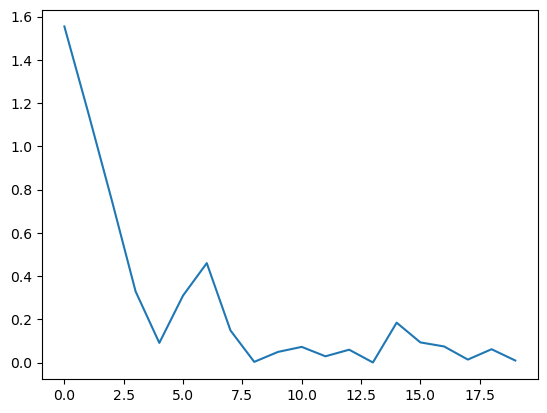

In [7]:
frac_error = np.abs(observables[1:, -1] - theoretical_obs) / np.abs(theoretical_obs)
plt.plot(frac_error)

In [18]:

@tf.function(input_signature=[
    tf.TensorSpec(shape=None, dtype=tf.int32),
    tf.TensorSpec(shape=None, dtype=tf.int32)
])
def test_fn(n_iter, sizes):
    observables = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    for i in tf.range(n_iter):
        
        obs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        j = 0
        for size in sizes:
            obs = obs.write(j, tf.cast(i + size, dtype=tf.float32))
            j += 1

        observables = observables.write(i, obs.stack())
        
    observables = observables.stack()
    return observables
        

In [19]:
test_fn(tf.constant(10), tf.constant([500, 1000]))

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 500., 1000.],
       [ 501., 1001.],
       [ 502., 1002.],
       [ 503., 1003.],
       [ 504., 1004.],
       [ 505., 1005.],
       [ 506., 1006.],
       [ 507., 1007.],
       [ 508., 1008.],
       [ 509., 1009.]], dtype=float32)>

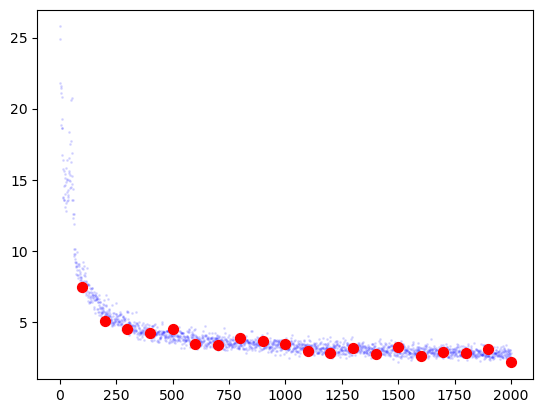

In [38]:
import numpy as np

train_iters = np.arange(n_iterations) + 1
eval_iters = np.arange(
    evaluate_every_n_iterations, 
    n_iterations+1,
    evaluate_every_n_iterations
)

losses = ave_losses.numpy()
plt.scatter(train_iters, losses, marker='.', alpha=0.1, c='b', s=5)
plt.scatter(eval_iters, losses[eval_iters-1], marker='o', c='r', s=50)

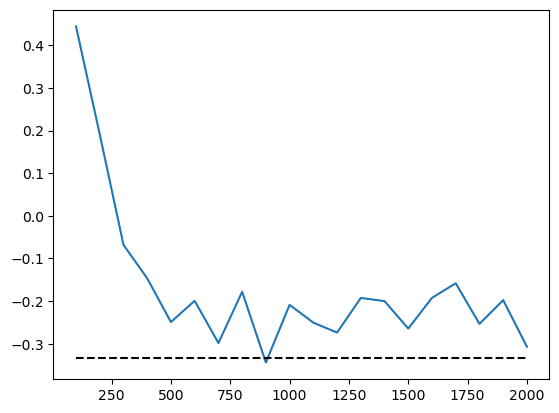

In [45]:
obs = agent_obss.numpy()
theo_obs = runner.env.theoretical_ave_dihedral_angle.numpy()

plt.plot(eval_iters, obs)
plt.hlines(
    theo_obs, eval_iters[0], eval_iters[-1], linestyles='dashed', colors='k'
)

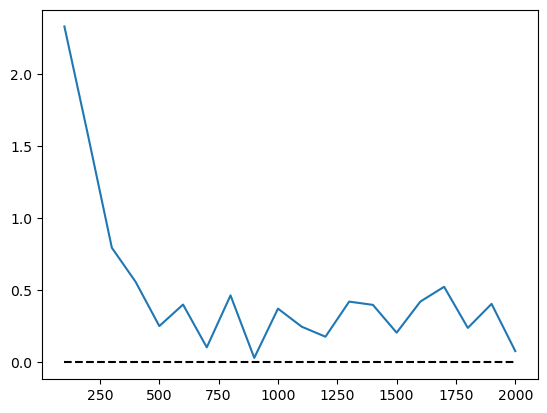

In [48]:
frac_error = np.abs(obs - theo_obs) / np.abs(theo_obs)

plt.plot(eval_iters, frac_error)
plt.hlines(
    0, eval_iters[0], eval_iters[-1], linestyles='dashed', colors='k'
)

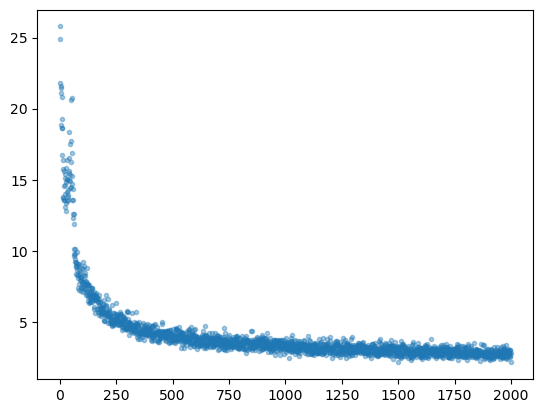

In [10]:
train_iters = tf.range(n_iterations) + 1
eval_iters = tf.range(
    start=evaluate_every_n_iterations, 
    limit=n_iterations+1, delta=evaluate_every_n_iterations
)

plt.scatter(train_iters.numpy(), ave_losses.numpy(), marker='.', alpha=0.4)
plt.scatter(eval_iters.numpy(), ave_losses.numpy(), marker='.', alpha=0.4)

In [ ]:
ave_losses

In [22]:



tf.gather(ave_losses, eval_iters - 1)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([7.473376 , 5.1014867, 4.5220137, 4.216411 , 4.4952617, 3.4349453,
       3.3476925, 3.8415563, 3.659858 , 3.4804347, 2.9827056, 2.8084044,
       3.1690488, 2.7217524, 3.2183037, 2.6279192, 2.8655064, 2.8271177,
       3.1274688, 2.1538713], dtype=float32)>

In [16]:
tf.where(tf.math.equal(tf.math.floormod(train_iters, evaluate_every_n_iterations), 0))

<tf.Tensor: shape=(20, 1), dtype=int64, numpy=
array([[  99],
       [ 199],
       [ 299],
       [ 399],
       [ 499],
       [ 599],
       [ 699],
       [ 799],
       [ 899],
       [ 999],
       [1099],
       [1199],
       [1299],
       [1399],
       [1499],
       [1599],
       [1699],
       [1799],
       [1899],
       [1999]])>

(0.0, 10.0)

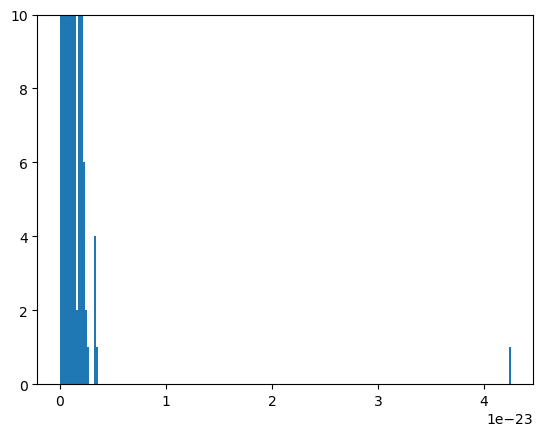

In [2]:
import matplotlib.pyplot as plt

sq_a = runner.env.squared_amplitudes.numpy().ravel()
rewards = runner.env.rewards.numpy().ravel()

plt.hist(sq_a, bins=200);
plt.ylim(0, 10)

(0.0, 10.0)

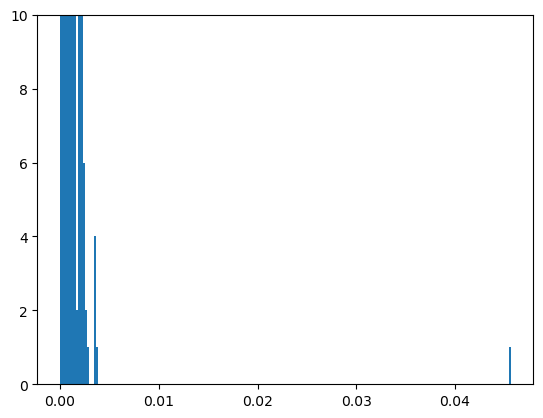

In [3]:
plt.hist(rewards, bins=200);
plt.ylim(0, 10)

In [3]:
import time

half_batch_size = tf.constant(500)
n_iterations = tf.constant(int(2e3))
# n_iterations = tf.constant(500)
evaluate_every_n_iterations = tf.constant(int(1e2))
evaluation_batch_size = tf.constant(int(5e4))

start = time.time()
ave_losses, ave_distr_errors, agent_obs = runner.train_agent(
    half_batch_size, n_iterations, evaluate_every_n_iterations, evaluation_batch_size
)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")
print(f"Average loss of last iteration: {float(ave_losses[-1])}")

Iteration: 0 Average Loss: 24.7875977
Iteration: 100 Average Loss: 7.34312201
Iteration: 200 Average Loss: 5.51297188
Iteration: 300 Average Loss: 3.9515698
Iteration: 400 Average Loss: 3.99993372
Iteration: 500 Average Loss: 3.39251661
Iteration: 600 Average Loss: 2.89663029
Iteration: 700 Average Loss: 2.66725802
Iteration: 800 Average Loss: 2.75563431
Iteration: 900 Average Loss: 2.79340911
Iteration: 1000 Average Loss: 3.15643024
Iteration: 1100 Average Loss: 3.20910263
Iteration: 1200 Average Loss: 3.01282525
Iteration: 1300 Average Loss: 2.94580626
Iteration: 1400 Average Loss: 3.10100198
Iteration: 1500 Average Loss: 2.68993187
Iteration: 1600 Average Loss: 2.51656222
Iteration: 1700 Average Loss: 2.84197402
Iteration: 1800 Average Loss: 2.69454932
Iteration: 1900 Average Loss: 2.47098184
Time Elapsed: 307.6863360404968 s
Average loss of last iteration: 2.967830181121826


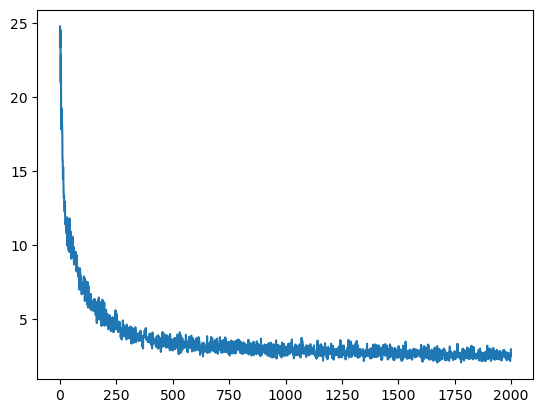

In [4]:
# import matplotlib.pyplot as plt

plt.plot(ave_losses.numpy())

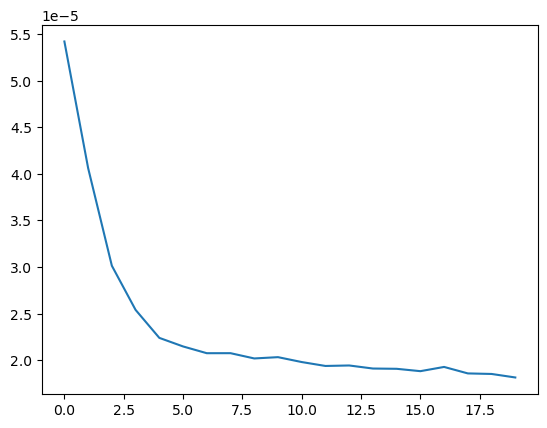

In [5]:
plt.plot(ave_distr_errors.numpy())
# ave_distr_errors

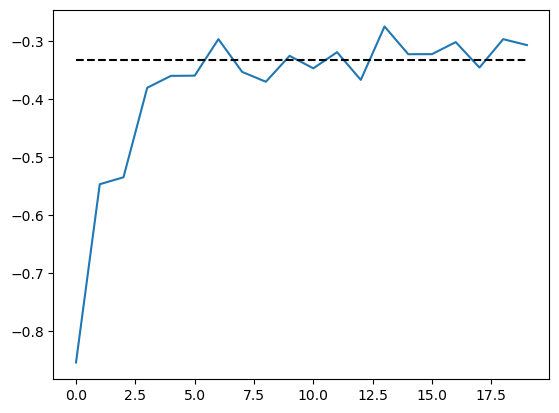

In [6]:
plt.plot(agent_obs.numpy())
plt.hlines(
    runner.env.theoretical_ave_dihedral_angle.numpy(),
    0, len(agent_obs) - 1, linestyles='dashed', colors='k'
)

In [8]:
runner.env.theoretical_ave_dihedral_angle.numpy()

-0.33333334

In [10]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)

In [19]:
import numpy as np

def _plot_l1_errors_per_probability_interval(agent_prob, env_prob, 
#                                              filename, 
                                             n_intervals
                                            ):
    result = agent_prob.ravel()
    expected = env_prob.ravel()
    max_expected = expected.max()
    expected_pcts = expected * 100 / max_expected

    interval_edges = np.linspace(0, 100, n_intervals + 1)
    starts = interval_edges[:-1]
    ends = interval_edges[1:]

#     frac_l1_errors = np.abs(result - expected) / max_expected
    l1_errors = np.abs(result - expected)
    errors = []
    labels = []
    for s, e in zip(starts, ends):
        inds = np.where((s < expected_pcts) & (expected_pcts <= e))
#         errors_per_interval = frac_l1_errors[inds]
        errors_per_interval = l1_errors[inds]
        if len(errors_per_interval):
            interval_label = f"{s:.2f}% < pct <= {e:.2f}%"
            max_expected_per_interval = expected[inds].max()
            errors.append(errors_per_interval / max_expected_per_interval)
            labels.append(interval_label)

#     print(errors)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.violinplot(errors)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, rotation=15)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Fractional L1 Errors")
    ax.set_xlabel("Percentage of max theoretical probability")
    plt.tight_layout()
#     fig.savefig(f"./plot_results/{filename}")
    return errors

In [20]:
batch_size = tf.constant(int(5e4))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

grid_dim = 5
n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 26.92%


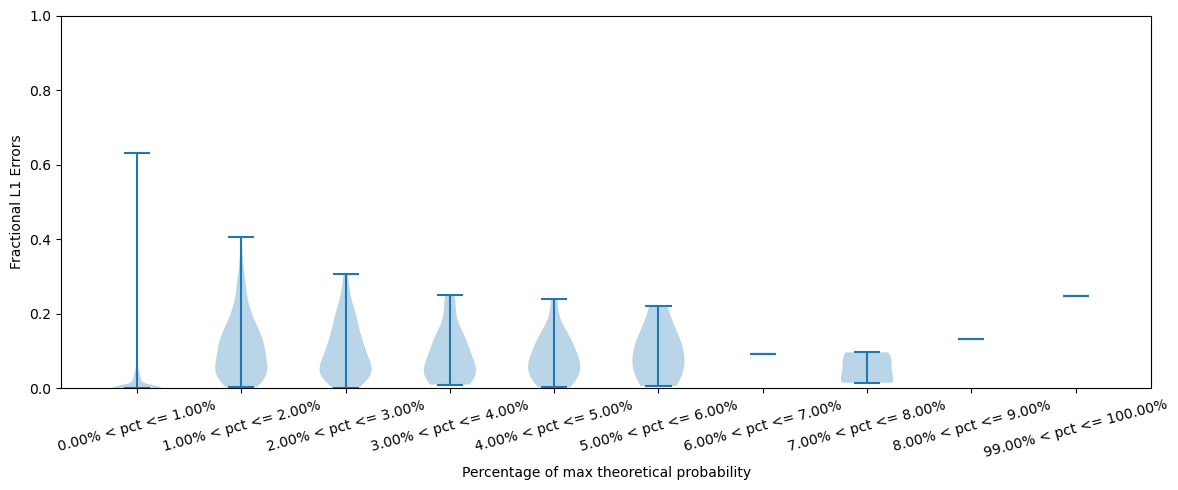

In [21]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=100
)

In [22]:
batch_size = tf.constant(int(1e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

grid_dim = 5
n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 34.56%


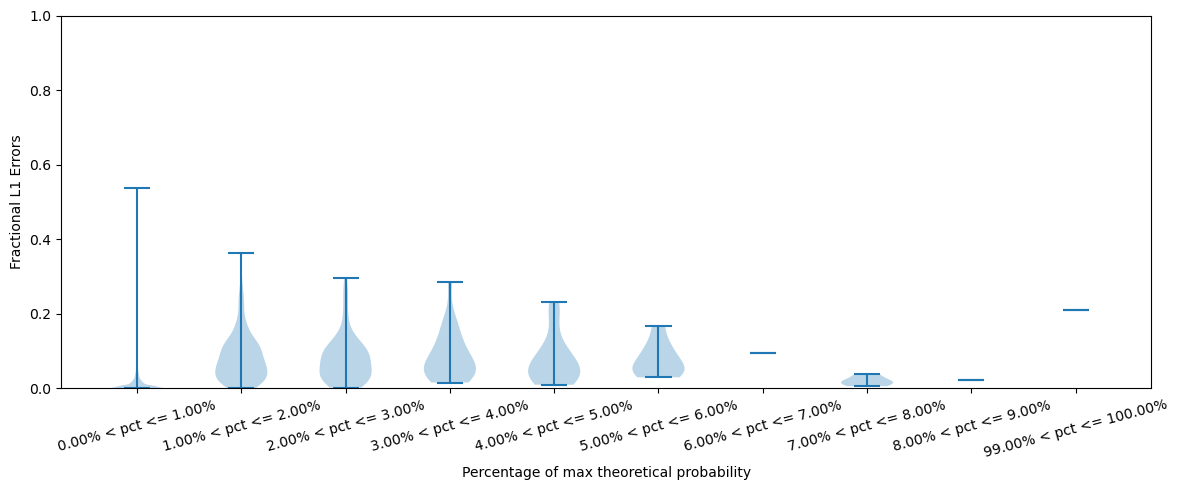

In [23]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=100
)

In [24]:
batch_size = tf.constant(int(5e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

grid_dim = 5
n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 51.66%


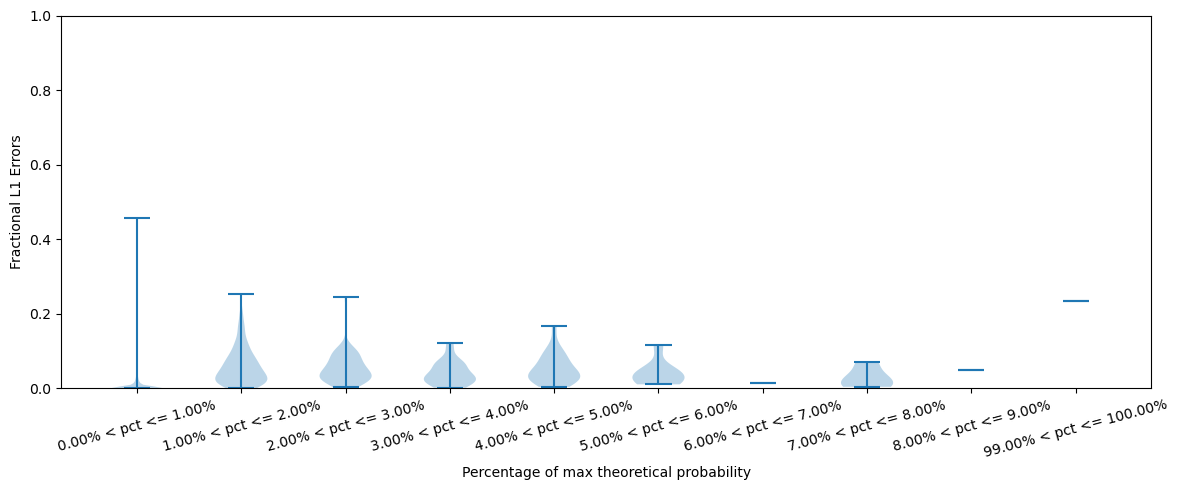

In [25]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=100
)